## Autoencoders 2
### Building a denoising autoencider using Keras API. We demonstrate that noise is successfully removed by passing several images of handwritten digits with added noise using different layers and a sparsity of 10%, 20% and 30%.

### Basic sets

In [1]:
import keras
from keras.layers import Input, Dense
from keras.models import Model

# this is the size of our encoded representations
encoding_dim = 32  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats

# this is our input placeholder
input_img = Input(shape=(784,))
# "encoded" is the encoded representation of the input
encoded = Dense(encoding_dim, activation='relu')(input_img)
# "decoded" is the lossy reconstruction of the input
decoded = Dense(784, activation='sigmoid')(encoded)

# this model maps an input to its reconstruction
autoencoder = Model(input_img, decoded)

C:\Users\Victor\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# this model maps an input to its encoded representation
encoder = Model(input_img, encoded)

In [3]:
# create a placeholder for an encoded (32-dimensional) input
encoded_input = Input(shape=(encoding_dim,))
# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# create the decoder model
decoder = Model(encoded_input, decoder_layer(encoded_input))

In [4]:
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

### Loading the data:

In [5]:
from keras.datasets import mnist
import numpy as np
(x_train, _), (x_test, _) = mnist.load_data()

In [6]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print (x_train.shape)
print (x_test.shape)

(60000, 784)
(10000, 784)


### Creating the network

In [7]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras import backend as K

input_img = Input(shape=(28, 28, 1))  # adapt this if using `channels_first` image data format

x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)
encoder = Model(input_img,encoded)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional

x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

### Setting sparsity:

In [8]:
from keras import regularizers

encoding_dim = 64

input_img = Input(shape=(784,))
# add a Dense layer with a L1 activity regularizer
encoded = Dense(encoding_dim, activation='relu',
                activity_regularizer=regularizers.l1(3.0))(input_img)
#encoder = Model(input_img,encoded)
decoded = Dense(784, activation='sigmoid')(encoded)

autoencoder = Model(input_img, decoded)


In [9]:
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

### Adding noise and presenting the images:

In [10]:
from keras.datasets import mnist
import numpy as np

(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))  # adapt this if using `channels_first` image data format
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))  # adapt this if using `channels_first` image data format

noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) 
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) 

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

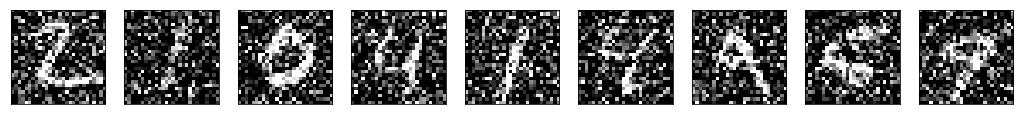

In [11]:
# use Matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
n = 10
plt.figure(figsize=(20, 2))
for i in range(1,n,1):
    ax = plt.subplot(1, n, i)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [12]:
input_img = Input(shape=(28, 28, 1))  # adapt this if using `channels_first` image data format

x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (7, 7, 32)

x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

### Training the network:

In [13]:
from keras.callbacks import TensorBoard
autoencoder.fit(x_train_noisy, x_train,
                epochs=100,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test_noisy, x_test),
                callbacks=[TensorBoard(log_dir='denoisy', histogram_freq=0, write_graph=False)])

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 323s 5ms/step - loss: 0.1996 - val_loss: 0.1418
Epoch 2/100
60000/60000 [==============================] - 296s 5ms/step - loss: 0.1351 - val_loss: 0.1286
Epoch 3/100
60000/60000 [==============================] - 296s 5ms/step - loss: 0.1277 - val_loss: 0.1245
Epoch 4/100
60000/60000 [==============================] - 300s 5ms/step - loss: 0.1270 - val_loss: 0.1211
Epoch 5/100
60000/60000 [==============================] - 298s 5ms/step - loss: 0.1219 - val_loss: 0.1246
Epoch 6/100
60000/60000 [==============================] - 297s 5ms/step - loss: 0.1204 - val_loss: 0.1211
Epoch 7/100
60000/60000 [==============================] - 297s 5ms/step - loss: 0.1189 - val_loss: 0.1188
Epoch 8/100
60000/60000 [==============================] - 298s 5ms/step - loss: 0.1198 - val_loss: 0.1143
Epoch 9/100
60000/60000 [==============================] - 296s 5ms/step - loss: 0.1180 - val_

### Presenting the denoised images:

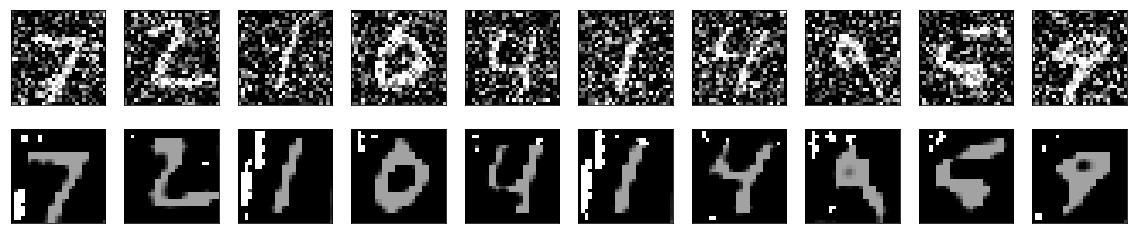

In [28]:
decoded_imgs = autoencoder.predict(x_test)


# use Matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original noisy images
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()